# Time Series Analysis

### Executive Summary

The goal of this analysis is to acquire earth surface temperature data offered by Berkeley Earth through Kaggle.com, cleaning and analyzing it to create Time Series models. These models were used to find trends in temperatures to make predictions for Pakistan. 

### Project Overview

- The data was cleaned by replacing null values, encoding new features for month and weekday as well as converting date to a date time object
- Our target variable is AverageTemperature
- The data was split into train, test and split dataframes before modeling to avoid data leakage and maintain data integrity
- The best model was fitted on the test data to predict Average Temperatures in Pakistan


In [1]:
import pandas as pd
import numpy as np

# datetime utilities
from datetime import timedelta, datetime

# visualization
import matplotlib.pyplot as plt

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

import statsmodels.api as sm
# holt's linear trend model. 
from statsmodels.tsa.api import Holt


In [2]:
# acquire data
df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

In [3]:
# quick look at data
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [4]:
# check max and min temperature in df

max_temp = df[df.AverageTemperature == df.AverageTemperature.max()]

min_temp = df[df.AverageTemperature == df.AverageTemperature.min()]

max_temp

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
17176,2000-07-01,38.283,0.436,Baghdad,Iraq,32.95N,45.00E


In [5]:
min_temp

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
82383,1922-01-01,-26.772,0.999,Harbin,China,45.81N,125.77E


In [6]:
# check nulls and data types of variables

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB


In [7]:
# check what countries are available to choose from 

df.Country.value_counts()

India                                 36582
China                                 35444
Brazil                                12930
Turkey                                 9473
United States                          8455
Egypt                                  7589
Pakistan                               7355
Canada                                 6478
Russia                                 6478
Nigeria                                5763
Colombia                               4542
Indonesia                              4530
Australia                              4146
Saudi Arabia                           4098
Japan                                  4095
South Africa                           3762
Germany                                3239
Ukraine                                3239
United Kingdom                         3239
Spain                                  3239
Italy                                  3239
France                                 3239
Morocco                         

In [8]:
# Location selected 

df.City[df.Country == 'Pakistan'].value_counts()

Karachi       2613
Lahore        2371
Faisalabad    2371
Name: City, dtype: int64

In [10]:
# how many nulls for temp in Pakistan

df.AverageTemperature[(df.Country=='Pakistan')].value_counts(dropna=False)

NaN       865
30.951      6
29.661      6
26.664      5
30.332      5
         ... 
18.420      1
31.536      1
24.226      1
27.685      1
27.660      1
Name: AverageTemperature, Length: 3995, dtype: int64

## Takeaways 

- AverageTemperature is the target variable
- Our location selected for this analysis is Pakistan 
    - We will filter the data to include only observations for Pakistan
    - There are over 7000 observations for Pakistan which is a good size
- There are a bunch of null values in AverageTemperature which will be taken care of in the next stage.
- dt is the date variable which will be converted to a datetime object before time series analysis.
- It looks like AverageTemperature is measured in degrees Celsius based on the minimum and maximum temperatures in the data.

## Prepare

### To Prepare Data

- create new df where the country is Pakistan and use that moving forward
- rename date column and drop original dt column
- convert date to datetime
- sort and set date as index
- grab average temperature, city, country
- fill nulls using interpolate
- split the df into train, validate and test dfs

In [11]:
def prep_data(df):
    
    # filter only for location selected
    df = df[df.Country == 'Pakistan']
    # rename dt to date, and drop original column of dt
    df = df.assign(date = df.dt).drop(columns=['dt'])
    #convert date to datetime
    df.date = pd.to_datetime(df.date)
    # set index and soty values
    df = df.set_index('date').sort_index()
    # select columns for new df
    df = df[['AverageTemperature', 'City', 'Country']]
    # add month column to df
    df['month'] = df.index.month
    # add day of week column to df
    df['day_of_week'] = df.index.day_name()
    # fill nulls using interpolate
    df = df.interpolate(method='linear')
    
    return df

In [12]:
# call the prep function
df = prep_data(df)

In [13]:
# quick look at prepared df
df.head()


,AverageTemperature,City,Country,month,day_of_week
date,,,,,
1796-01-01,17.996,Karachi,Pakistan,1,Friday
1796-02-01,20.203,Karachi,Pakistan,2,Monday
1796-03-01,23.303,Karachi,Pakistan,3,Tuesday
1796-04-01,28.124,Karachi,Pakistan,4,Friday
1796-05-01,31.394,Karachi,Pakistan,5,Sunday


In [14]:
# number of rows and columns in prepped df
df.shape

(7355, 5)

In [15]:
# check if nulls taken care of

df.AverageTemperature.isnull().any()

False

Text(0.5, 1.0, 'Average Temperature by Date')

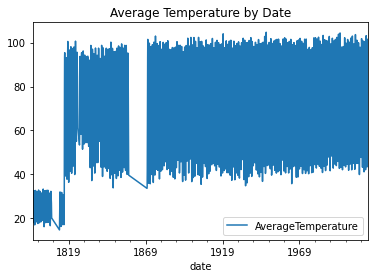

In [16]:
# visualize average temp by date

by_date = df.groupby('date').AverageTemperature.sum().reset_index()
by_date.plot(x='date', y='AverageTemperature')
plt.title('Average Temperature by Date')

<AxesSubplot:xlabel='date'>

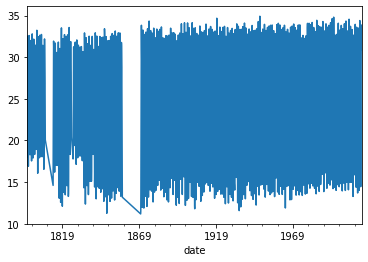

In [17]:
# Resample by the month and take the average temperature. Visualize the average temperature over time.

df.AverageTemperature.resample('M').mean().plot()


- There does not seem to be much value in visualizing by month and date. We can resample by a larger time period and see if that will provide more value.

<AxesSubplot:xlabel='date'>

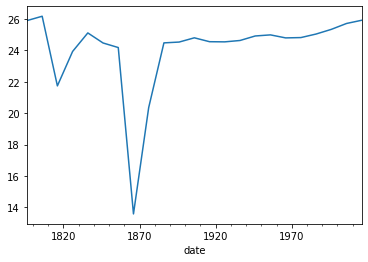

In [18]:
# visualize the mean temperature every 10 years 

df.AverageTemperature.resample('10Y').mean().plot()

- This looks better!
- Looks like the mean temperature is lowest around 1865 
- there is a small dip in mean temperature around 1815

<AxesSubplot:xlabel='date'>

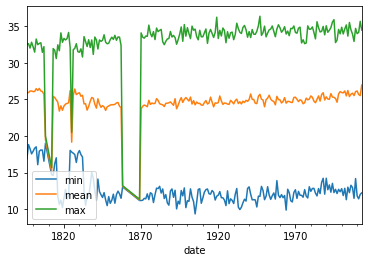

In [19]:
#Visualize the yearly min, average, and max temperature over time on a single line plot, 

df.AverageTemperature.resample('Y').agg(['min', 'mean', 'max']).plot()

<AxesSubplot:xlabel='date'>

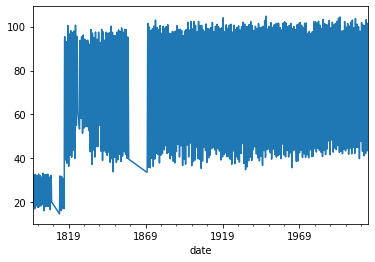

In [20]:
df.AverageTemperature.resample('M').sum().plot()

<AxesSubplot:xlabel='month'>

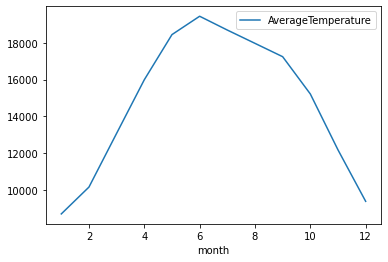

In [21]:
# visualize temp by month
by_month = df.groupby(['month']).AverageTemperature.sum().reset_index()
by_month.plot(x='month', y='AverageTemperature')

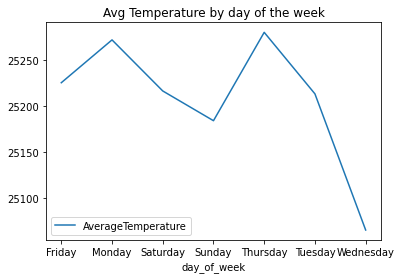

In [61]:
by_month = df.groupby(['day_of_week']).AverageTemperature.sum().reset_index()
by_month.plot(x='day_of_week', y='AverageTemperature')
plt.title('Avg Temperature by day of the week')
plt.show()

- hottest month seems to be June after which temperatures decrease until December
- Coldest month seems to be January
- Looks like Thursday is the hottest day of the week and Wednesday is the coldest with the lowest Average temperature

In [23]:
# date range in df

df.index.min(), df.index.max()

(Timestamp('1796-01-01 00:00:00'), Timestamp('2013-09-01 00:00:00'))

In [24]:
def split_data(df):
    '''
    This function takes in a dataframe and splits it into a train, validate, and test set
    with respect to time
    '''
    
    # assign lengths of each dataframe
    train_size = int(len(df) * 0.5)
    validate_size = int(len(df) * 0.3)
    test_size = int(len(df) - train_size - validate_size)
    
    validate_end_index = train_size + validate_size
    
    # assign rows to each dataframe
    train = df[:train_size]
    validate = df[train_size:validate_end_index]
    test = df[validate_end_index:]
    
    return train, validate, test

In [25]:
# call split function 

train, validate, test = split_data(df)

In [26]:
# check shapes of splits

train.shape, validate.shape, test.shape

((3677, 5), (2206, 5), (1472, 5))

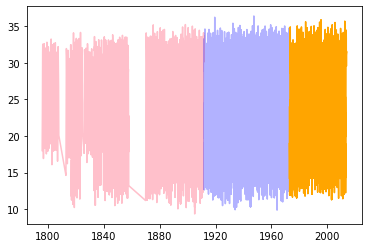

In [27]:
# visualize temps for each split

plt.plot(train.index, train.AverageTemperature, color='pink')
plt.plot(validate.index, validate.AverageTemperature, color='blue', alpha = 0.3)
plt.plot(test.index, test.AverageTemperature, color = 'orange')

- There does not seem to be a huge difference in temperatures between the splits.
- The initial temperatures were lower and after 1840 the temperatures seem to be pretty consistent.

<AxesSubplot:xlabel='date'>

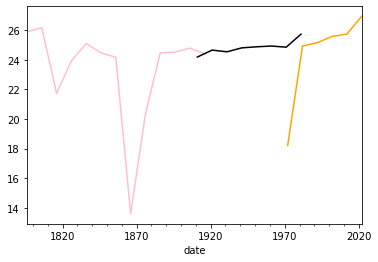

In [28]:
# resample every 10 years and visualize 
train.AverageTemperature.resample('10Y').mean().plot(color='pink')
validate.AverageTemperature.resample('10Y').mean().plot(color='black')
test.AverageTemperature.resample('10Y').mean().plot(color='orange')


- There are some dips over time but the last temperature value is higher than the initial temperature indicating an updward trend in average temperature.

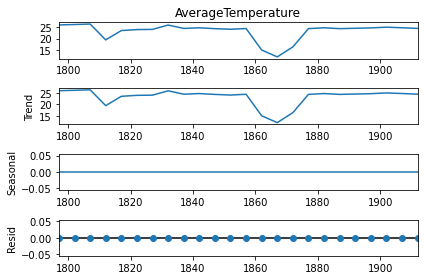

In [29]:
# check seasonal trends

sm.tsa.seasonal_decompose(train.AverageTemperature.resample('5Y').mean()).plot()
plt.show()

In [30]:
# assign target variable

y = train.resample('5Y').AverageTemperature.mean()

In [31]:
# summary stats of target variable

y.describe()


count    24.000000
mean     23.177193
std       3.633605
min      12.103612
25%      23.943883
50%      24.356430
75%      24.658422
max      26.268950
Name: AverageTemperature, dtype: float64

Text(0, 0.5, 'Difference in avg temp every 5 years')

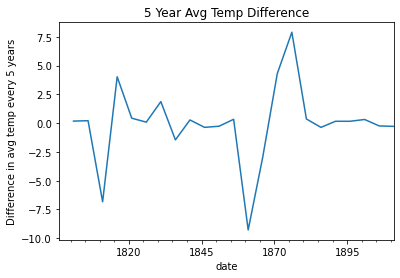

In [32]:
# plot temp different every 5 years

y.diff().plot()
plt.title('5 Year Avg Temp Difference')
plt.ylabel('Difference in avg temp every 5 years')

<AxesSubplot:xlabel='date'>

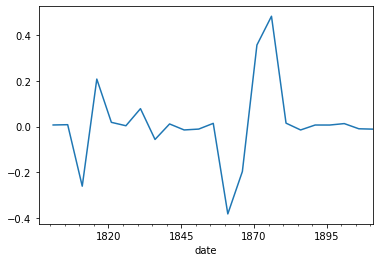

In [33]:
# visualize percent change in temp 

y.pct_change().plot()

### Takeaways

- Highest temp difference between 1860 -1875
- another big temp change between 1810 - 1815
- minor fluctuations otherwise

### Forecasting

We will compute RMSE and use that to compare each model. Before we begin modeling, we will set up functions to utilize for evaluation and visualization.

In [34]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = sqrt(mean_squared_error(validate[target_var], yhat_df[target_var]))
    return rmse

In [35]:
# plot and evaluate 

def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [36]:
# Create the empty dataframe for evaluation metrics

eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


In [37]:
eval_df

,model_type,target_var,rmse


### Forecast

#### Moving Average method
First we will start with a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

In [38]:
# demonstrate that the mean of the first 30 days is equal to rolling(30) on day 30

print(train['AverageTemperature'].rolling(30).mean())

date
1796-01-01          NaN
1796-02-01          NaN
1796-03-01          NaN
1796-04-01          NaN
1796-05-01          NaN
                ...    
1911-06-01    22.901567
1911-06-01    22.987333
1911-07-01    23.109100
1911-07-01    23.111367
1911-07-01    23.297200
Name: AverageTemperature, Length: 3677, dtype: float64


### Make predictions

In [39]:
period = 30 

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temps = train['AverageTemperature'].rolling(period).mean()[-1]
print(temps)

23.297199999999997


In [40]:
def make_predictions():
    yhat_df = pd.DataFrame({'AverageTemperature': [temps],
                           },
                          index=validate.index)
    return yhat_df

In [41]:
yhat_df = make_predictions()

yhat_df.head()

,AverageTemperature
date,
1911-08-01,23.2972
1911-08-01,23.2972
1911-08-01,23.2972
1911-09-01,23.2972
1911-09-01,23.2972


### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using Moving Average

AverageTemperature -- RMSE: 7


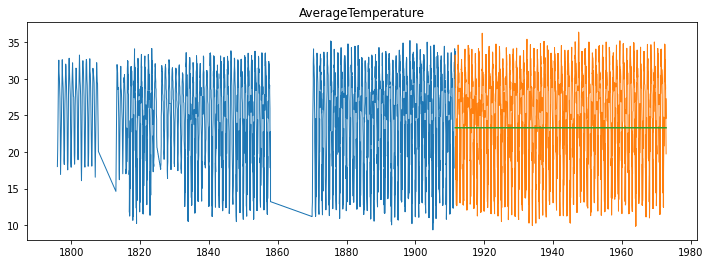

In [42]:
plot_and_eval('AverageTemperature')

In [43]:
eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = 'AverageTemperature')


In [44]:
eval_df

,model_type,target_var,rmse
0,30d_moving_avg,AverageTemperature,7.164134


In [45]:
# try out different periods for moving average

periods = [24, 52, 104]

for p in periods: 
    temps = train['AverageTemperature'].rolling(p).mean()[-1]
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
    eval_df = append_eval_df(model_type = model_type, 
                                 target_var = 'AverageTemperature')

In [46]:
eval_df


,model_type,target_var,rmse
0,30d_moving_avg,AverageTemperature,7.164134
1,24d_moving_avg,AverageTemperature,7.125285
2,52d_moving_avg,AverageTemperature,7.027447
3,104d_moving_avg,AverageTemperature,7.048914


- lowest rmse is for the 52d moving average

### Last Observed Value Method

In [47]:
# last observed value
temps = train['AverageTemperature'][-1:][0]
temps

33.678999999999995

In [48]:
yhat_df2 = pd.DataFrame({'AverageTemperature': [temps]}, 
                      index = validate.index)

yhat_df2.head()

,AverageTemperature
date,
1911-08-01,33.679
1911-08-01,33.679
1911-08-01,33.679
1911-09-01,33.679
1911-09-01,33.679


In [49]:
yhat_df2.describe()

,AverageTemperature
count,2.206000e+03
mean,3.367900e+01
std,1.087377e-12
min,3.367900e+01
25%,3.367900e+01
50%,3.367900e+01
75%,3.367900e+01
max,3.367900e+01


### Plot Actual vs. Predicted Values

Now, let's plot actual and predicted values

AverageTemperature -- RMSE: 7


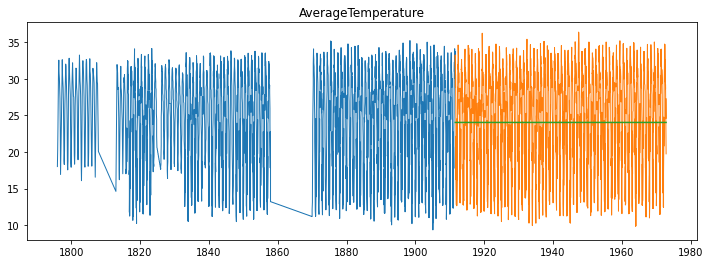

In [50]:
plot_and_eval('AverageTemperature')


In [51]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'AverageTemperature')

eval_df

,model_type,target_var,rmse
0,30d_moving_avg,AverageTemperature,7.164134
1,24d_moving_avg,AverageTemperature,7.125285
2,52d_moving_avg,AverageTemperature,7.027447
3,104d_moving_avg,AverageTemperature,7.048914
4,last_observed_value,AverageTemperature,7.048914


- The rmse for last observed value method is the same as 104d moving average
- We will fit last observed value on test split

### Fitting on test split

Only the best performing model with the lowest RMSE will be fitted on the test split. This will evaluate the model's perfomance on out of sample data. 


In [52]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.legend()
    plt.show()

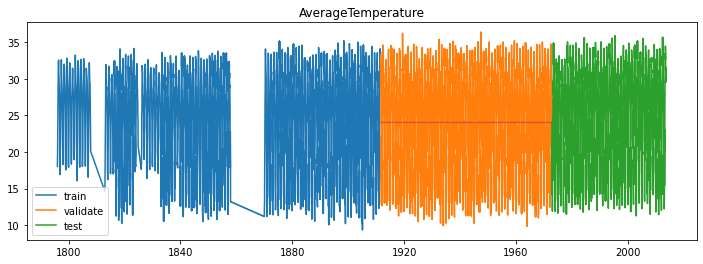

In [53]:
final_plot('AverageTemperature')

In [56]:
def make_predictions():
    
    yhat_df_test = pd.DataFrame({'AverageTemperature': [temps],
                           },
                          index=test.index)
    return yhat_df_test

In [57]:
yhat_df_test = make_predictions()
yhat_df_test.head()

,AverageTemperature
date,
1972-11-01,33.679
1972-11-01,33.679
1972-12-01,33.679
1972-12-01,33.679
1972-12-01,33.679


In [58]:
rmse_test = sqrt(mean_squared_error(test['AverageTemperature'], 
                                       yhat_df_test['AverageTemperature']))
rmse_test

10.788855475794522

- RMSE is slightly higher on the test split indicating the model might be overfit 
- This RMSE is quite high and with more time, I would explore models that could help in lowering the RMSE